# lab 5: translation simple ecoder-decocer over the b2 dataset

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext import data
import pandas as pd
import unicodedata
import string
import re
import random
from contra_qa.plots.functions  import simple_step_plot
import  matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from nltk.translate.bleu_score import sentence_bleu


% matplotlib inline

### Preparing data

In [2]:
df2 = pd.read_csv("data/boolean2_train.csv")

df2train = df2.iloc[:8500]
df2valid = df2.iloc[8500:]

In [3]:
df2train.tail()

,sentence1,sentence2,and_A,and_B,label
8495,Agnes is proud and Lauren is ambitious,Agnes is not proud,Agnes is proud,Lauren is ambitious,1
8496,Curtis is wonderful and Jessie is ambitious,Curtis is not wonderful,Curtis is wonderful,Jessie is ambitious,1
8497,Brett is dead and Tracy is important,Tracy is not important,Brett is dead,Tracy is important,1
8498,Lauren is hallowed and Yvette is shy,Yvette is not shy,Lauren is hallowed,Yvette is shy,1
8499,Kathleen is alive and Dustin is clever,Dustin is not clever,Kathleen is alive,Dustin is clever,1


In [4]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [5]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

# Lowercase, trim, and remove non-letter characters

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s


example = "ddddda'''~~çãpoeéééééÈ'''#$$##@!@!@AAS@#12323fdf"
print("Before:", example)
print()
print("After:", normalizeString(example))

Before: ddddda'''~~çãpoeéééééÈ'''#$$##@!@!@AAS@#12323fdf

After: ddddda capoeeeeeee ! ! aas fdf


In [6]:
pairs_A = list(zip(list(df2train.sentence1.values), list(df2train.and_A.values)))
pairs_B = list(zip(list(df2train.sentence1.values), list(df2train.and_B.values)))
pairs_A = [(normalizeString(s1), normalizeString(s2)) for s1, s2 in pairs_A]
pairs_B = [(normalizeString(s1), normalizeString(s2)) for s1, s2 in pairs_B]
pairs_A_val = list(zip(list(df2valid.sentence1.values), list(df2valid.and_A.values)))
pairs_B_val = list(zip(list(df2valid.sentence1.values), list(df2valid.and_B.values)))
pairs_A_val = [(normalizeString(s1), normalizeString(s2)) for s1, s2 in pairs_A_val]
pairs_B_val = [(normalizeString(s1), normalizeString(s2)) for s1, s2 in pairs_B_val]


In [7]:
def readLangs(lang1, lang2, pairs, reverse=False):
    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [tuple(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [8]:
MAX_LENGTH = 20


def filterPair(p):
    cond1 = len(p[0].split(' ')) < MAX_LENGTH
    cond2 = len(p[1].split(' ')) < MAX_LENGTH 
    return cond1 and cond2


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]


In [9]:
def prepareData(lang1, lang2, pairs, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, pairs, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [10]:
input_lang, output_lang, training_pairs_A = prepareData("eng_enc",
                                             "eng_dec",
                                             pairs_A)

print()
_, _, valid_pairs_A = prepareData("eng_enc",
                                "eng_dec",
                                pairs_A_val)

Read 8500 sentence pairs
Trimmed to 8500 sentence pairs
Counting words...
Counted words:
eng_enc 705
eng_dec 704

Read 1500 sentence pairs
Trimmed to 1500 sentence pairs
Counting words...
Counted words:
eng_enc 696
eng_dec 644


In [11]:
_, _, training_pairs_B = prepareData("eng_enc",
                                     "eng_dec",
                                     pairs_B)
print()
_, _, valid_pairs_B = prepareData("eng_enc",
                                "eng_dec",
                                pairs_B_val)

Read 8500 sentence pairs
Trimmed to 8500 sentence pairs
Counting words...
Counted words:
eng_enc 705
eng_dec 704

Read 1500 sentence pairs
Trimmed to 1500 sentence pairs
Counting words...
Counted words:
eng_enc 696
eng_dec 638


### sentences 2 tensors

In [12]:
example = random.choice(training_pairs_A)
print(example)

('cora is uninterested and molly is gifted', 'cora is uninterested')


In [13]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

In [14]:
indexesFromSentence(input_lang,example[0])

[386, 3, 11, 5, 572, 3, 26]

In [15]:
indexesFromSentence(output_lang, example[1])

[252, 3, 113]

In [16]:
def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

In [17]:
input_sen = tensorFromSentence(input_lang,example[0])
output_sen = tensorFromSentence(output_lang, example[1])

print(input_sen)
print()
print(input_sen.shape)
print(input_sen.dtype)
print(output_sen)
print()
print(output_sen.shape)
print(output_sen.dtype)

tensor([[386],
        [  3],
        [ 11],
        [  5],
        [572],
        [  3],
        [ 26],
        [  1]])

torch.Size([8, 1])
torch.int64
tensor([[252],
        [  3],
        [113],
        [  1]])

torch.Size([4, 1])
torch.int64


In [18]:
def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [19]:
input_sen, output_sen = tensorsFromPair(example)


print("input\n")
print(input_sen)
print()
print(input_sen.shape)
print(input_sen.dtype)

print("\noutput\n")
print(output_sen)
print()
print(output_sen.shape)
print(output_sen.dtype)

input

tensor([[386],
        [  3],
        [ 11],
        [  5],
        [572],
        [  3],
        [ 26],
        [  1]])

torch.Size([8, 1])
torch.int64

output

tensor([[252],
        [  3],
        [113],
        [  1]])

torch.Size([4, 1])
torch.int64


In [20]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [21]:
hidden_size = 10
eng_enc_v_size = 705
eng_dec_v_size = 704

In [22]:
encoder = EncoderRNN(eng_enc_v_size, hidden_size)
h0 = encoder.initHidden()
print("input_sen:", input_sen.shape, input_sen.dtype)
print("h0:", h0.shape, h0.dtype)

input_sen: torch.Size([8, 1]) torch.int64
h0: torch.Size([1, 1, 10]) torch.float32


In [23]:
max_length = MAX_LENGTH
encoder_outputs = torch.zeros(max_length,
                              encoder.hidden_size,
                              device=device)

input_length = input_sen.size(0)

for ei in range(input_length):
    output, hidden_enc = encoder(input_sen[ei], h0)
    h0 = hidden_enc
    encoder_outputs[ei] = output[0, 0]

print("output:", output.shape, output.dtype)
print("hidden_enc:", hidden_enc.shape, hidden_enc.dtype)

output: torch.Size([1, 1, 10]) torch.float32
hidden_enc: torch.Size([1, 1, 10]) torch.float32


In [24]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [25]:
decoder = DecoderRNN(hidden_size, eng_dec_v_size)

decoder_input = torch.tensor([[SOS_token]], device=device)

decoder_hidden = hidden_enc

target_length = output_sen.size(0)

for di in range(target_length):
    decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
    decoder_input = output_sen[di]  # Teacher forcing
    print("decoder_output:", decoder_output.shape, decoder_output.dtype)
    print()
    print("decoder_hidden:", decoder_hidden.shape, decoder_hidden.dtype)    


decoder_output: torch.Size([1, 704]) torch.float32

decoder_hidden: torch.Size([1, 1, 10]) torch.float32
decoder_output: torch.Size([1, 704]) torch.float32

decoder_hidden: torch.Size([1, 1, 10]) torch.float32
decoder_output: torch.Size([1, 704]) torch.float32

decoder_hidden: torch.Size([1, 1, 10]) torch.float32
decoder_output: torch.Size([1, 704]) torch.float32

decoder_hidden: torch.Size([1, 1, 10]) torch.float32


## Calculate loss over each token of the target language

In [26]:
learning_rate = 0.2
encoder_optimizer = torch.optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = torch.optim.SGD(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

In [27]:
def train(input_tensor,
          target_tensor,
          encoder,
          decoder,
          encoder_optimizer,
          decoder_optimizer,
          criterion,
          max_length,
          teacher_forcing_ratio=0.5):

    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length,
                                  encoder.hidden_size,
                                  device=device)
    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
    use_teacher_forcing = True

    if not random.random() < teacher_forcing_ratio:
        use_teacher_forcing = False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            _, topone = decoder_output.topk(1)
            decoder_input = topone.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [28]:
def get_loss(input_tensor,
             target_tensor,
             encoder,
             decoder,
             criterion,
             max_length):

    encoder_hidden = encoder.initHidden()
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    encoder_outputs = torch.zeros(max_length,
                                  encoder.hidden_size,
                                  device=device)
    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
    
    for di in range(target_length):
        decoder_output, decoder_hidden = decoder(
            decoder_input, decoder_hidden)
        _, topone = decoder_output.topk(1)
        decoder_input = topone.squeeze().detach()  # detach from history as input

        loss += criterion(decoder_output, target_tensor[di])
        if decoder_input.item() == EOS_token:
            break
    return loss.item() / target_length

Test get loss

In [29]:
valid_pairs = [tensorsFromPair(pair) for pair in valid_pairs_A]
valid_loss = []
for t in valid_pairs:
    input_sen, output_sen = t
    loss = get_loss(input_sen,
                    output_sen,
                    encoder,
                    decoder,
                    criterion,
                    MAX_LENGTH)
    valid_loss.append(loss)
print("mean loss", np.mean(valid_loss))

mean loss 6.539882694880168


In [30]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since):
    now = time.time()
    s = now - since
    return '%s' % asMinutes(s)

Test train

0m 5s


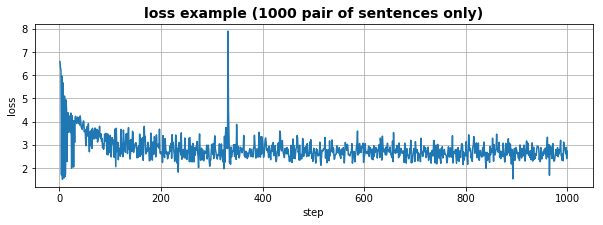

In [31]:
n_iters = 1000
training_pairs_little = [tensorsFromPair(random.choice(training_pairs_A)) for i in range(n_iters)]

losses = []
start = time.time()

for t in training_pairs_little:
    input_sen, output_sen = t    
    loss = train(input_sen,
                 output_sen,
                 encoder,
                 decoder,
                 encoder_optimizer,
                 decoder_optimizer,
                 criterion,
                 max_length=MAX_LENGTH)
    losses.append(loss)

print(timeSince(start))

simple_step_plot([losses],
                 "loss",
                 "loss example ({} pair of sentences only)".format(n_iters),
                 "loss_example.png",
                  figsize=(10,3))

In [32]:
def trainIters(encoder,
               decoder,
               n_iters,
               pairs,
               valid_pairs,
               encoder_path,
               decoder_path,
               batch_size=32,
               status_every=100,
               learning_rate=0.01,
               teacher_forcing_ratio=0.5):

    plot_losses = []
    old = 0
    start = time.time()
    all_loss = []
    valid_loss = float("inf")
    
    

    encoder_optimizer = torch.optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = torch.optim.SGD(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]

    for i, t in enumerate(training_pairs):
        input_sen, output_sen = t
        loss = train(input_sen,
                     output_sen,
                     encoder,
                     decoder,
                     encoder_optimizer,
                     decoder_optimizer,
                     criterion,
                     max_length=MAX_LENGTH,
                     teacher_forcing_ratio=teacher_forcing_ratio)
        plot_losses.append(loss)

        if i % status_every == 0 and i != 0:
            valid_batch = [tensorsFromPair(random.choice(valid_pairs))
                           for i in range(batch_size)]
            batch_loss = 0
            for t in valid_batch:
                input_sen, output_sen = t
                batch_loss += get_loss(input_sen,
                                       output_sen,
                                       encoder,
                                       decoder,
                                       criterion,
                                       MAX_LENGTH)
            current_valid_loss = batch_loss / batch_size
            
            if current_valid_loss < valid_loss:
                valid_loss = current_valid_loss
                torch.save(encoder.state_dict(), encoder_path)
                torch.save(decoder.state_dict(), decoder_path)
            print("mean training loss = {:.2f}".format(np.mean(plot_losses)))
            print("mean valid loss = {:.2f}".format(current_valid_loss))
            print("time in {} steps:".format(status_every), timeSince(start))
            print()
            simple_step_plot([plot_losses],
                             "loss",
                             "loss plot (from {} to {})".format(old, i),
                             "loss_example.png",
                             figsize=(10, 3))
            all_loss += plot_losses
            plot_losses = []
            old = i
            start = time.time()
    
    simple_step_plot([all_loss],
                     "loss",
                     "loss over training" ,
                     "loss_example.png",
                     figsize=(15, 3))


mean training loss = 2.59
mean valid loss = 2.61
time in 100 steps: 0m 0s

mean training loss = 2.58
mean valid loss = 2.53
time in 100 steps: 0m 0s

mean training loss = 2.61
mean valid loss = 2.60
time in 100 steps: 0m 0s

mean training loss = 2.60
mean valid loss = 2.60
time in 100 steps: 0m 0s

mean training loss = 2.62
mean valid loss = 2.60
time in 100 steps: 0m 0s

mean training loss = 2.57
mean valid loss = 2.56
time in 100 steps: 0m 0s

mean training loss = 2.62
mean valid loss = 2.59
time in 100 steps: 0m 0s

mean training loss = 2.63
mean valid loss = 2.60
time in 100 steps: 0m 0s

mean training loss = 2.60
mean valid loss = 2.58
time in 100 steps: 0m 0s



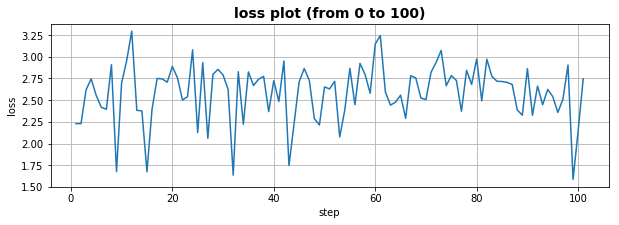

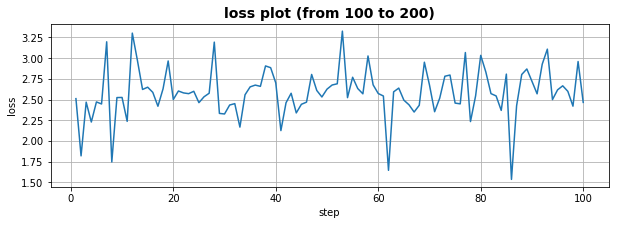

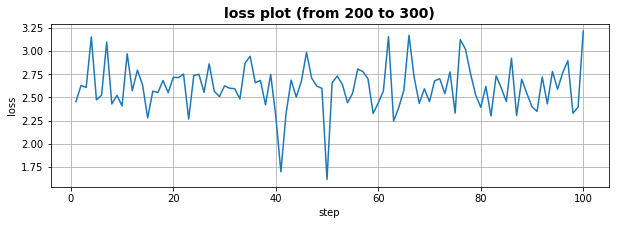

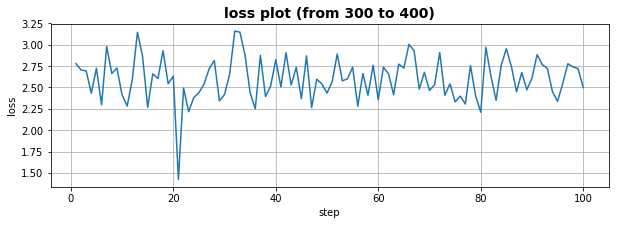

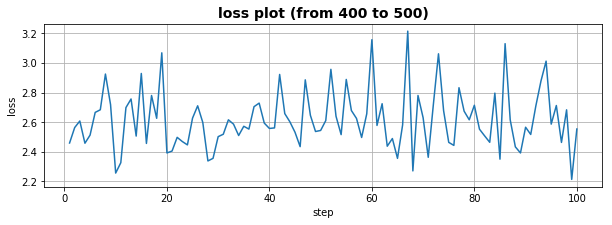

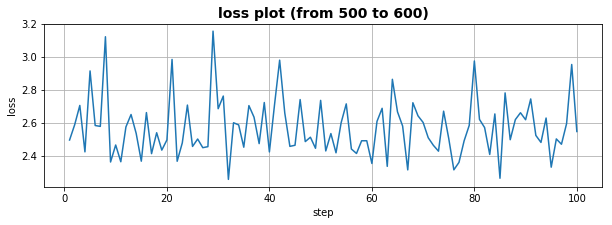

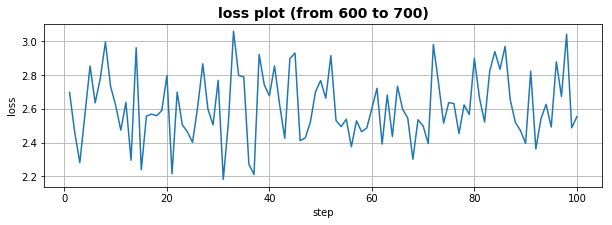

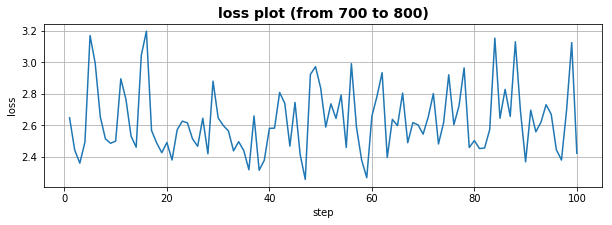

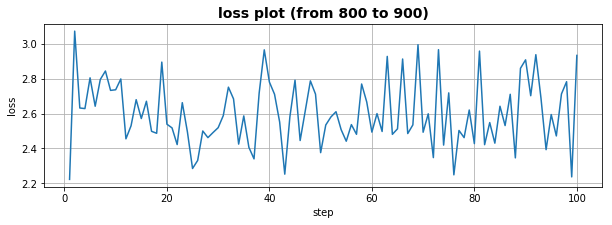

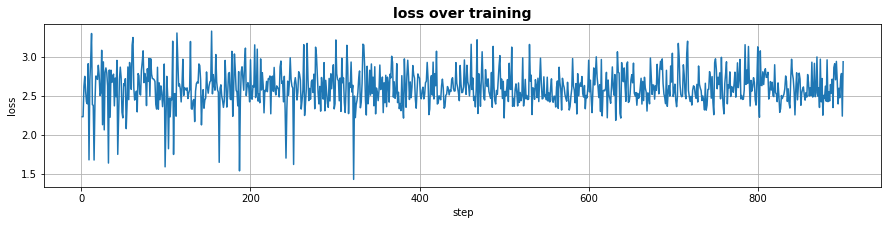

In [33]:
trainIters(encoder=encoder,
           decoder=decoder,
           n_iters=1000,
           pairs=training_pairs_A,
           valid_pairs=valid_pairs_A,
           encoder_path="encoder.pkl",
           decoder_path="decoder.pkl",
           batch_size=32,
           status_every=100,
           learning_rate=0.01,
           teacher_forcing_ratio=0.5)

## translating

In [34]:
def translate(encoder,
              decoder,
              sentence,
              max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(
            max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            _, topone = decoder_output.data.topk(1)
            if topone.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topone.item()])

            decoder_input = topone.squeeze().detach()

        return " ".join(decoded_words)

## translation of a non trained model

In [35]:
encoder = EncoderRNN(eng_enc_v_size, hidden_size)
decoder = DecoderRNN(hidden_size, eng_dec_v_size)

np.random.shuffle(training_pairs_A)

In [36]:
for t in training_pairs_A[0:3]:
    print("input_sentence : " + t[0])
    neural_translation = translate(encoder,
                                   decoder,
                                   t[0],
                                   max_length=MAX_LENGTH)
    print("neural translation : " + neural_translation)
    reference = t[1] + ' <EOS>'
    print("reference translation : " + reference)
    reference = reference.split(" ")
    candidate = neural_translation.split(" ")
    score = sentence_bleu([reference], candidate)
    print("blue score = {:.2f}".format(score))
    print()


input_sentence : hugh is rich and gilbert is hallowed
neural translation : randy larry larry larry larry larry larry larry larry larry larry larry larry larry larry larry larry larry larry larry
reference translation : hugh is rich <EOS>
blue score = 0.00

input_sentence : tyrone is victorious and adam is powerful
neural translation : randy larry larry larry larry larry larry larry larry larry larry larry larry larry larry larry larry larry larry larry
reference translation : tyrone is victorious <EOS>
blue score = 0.00

input_sentence : clara is wonderful and arnold is easy
neural translation : randy larry larry larry larry larry larry larry larry larry larry larry larry larry larry larry larry larry larry larry
reference translation : clara is wonderful <EOS>
blue score = 0.00



## Training some models and observing its translation

In [37]:
def save_translation(pairs, encoder, decoder, max_length, out_path):
    with open(out_path, "w") as file:
        file.write("source,candidate,reference,blue,accuracy\n")        
        for tuple_ in pairs:
            source, reference = tuple_
            candidate = translate(encoder,
                                  decoder,
                                  source,
                                  max_length=max_length)
            reference =  reference + ' <EOS>'
            blue = sentence_bleu([reference.split(" ")], candidate.split(" "))
            if blue >= 0.95:
                acc = 1
            else:
                acc = 0
            line = source + ","
            line += candidate + ","
            line += reference + ","
            line += "{:.3f},".format(blue)
            line += "{}\n".format(acc)
            file.write(line)

Test save_translation

In [38]:
save_translation(training_pairs_A[0:3],
                 encoder,
                 decoder,
                 MAX_LENGTH,
                 "temp.csv")

### Training 1

mean training loss = 3.89
mean valid loss = 4.29
time in 1000 steps: 0m 6s

mean training loss = 2.89
mean valid loss = 4.61
time in 1000 steps: 0m 6s

mean training loss = 2.71
mean valid loss = 5.01
time in 1000 steps: 0m 6s

mean training loss = 2.67
mean valid loss = 4.33
time in 1000 steps: 0m 6s



/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


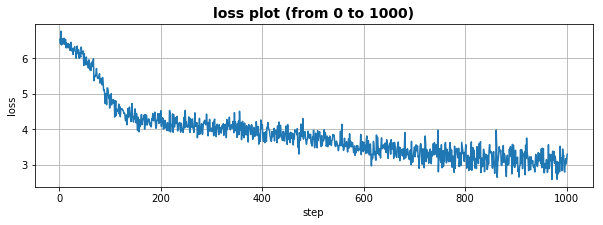

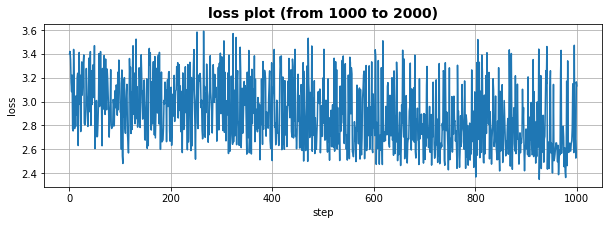

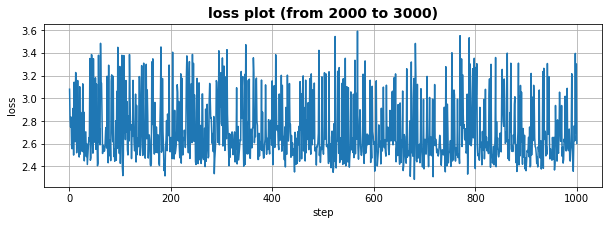

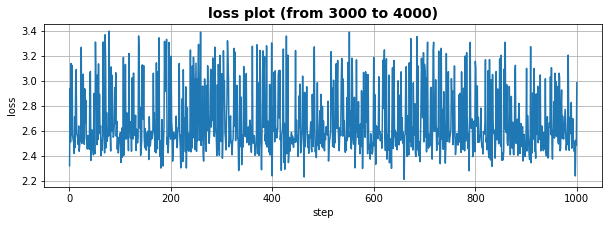

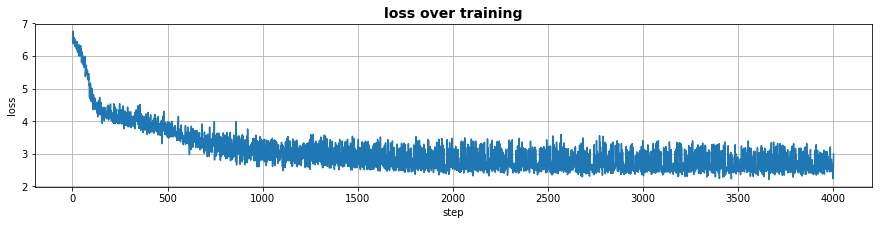

In [39]:
encoder = EncoderRNN(eng_enc_v_size, hidden_size)
decoder = DecoderRNN(hidden_size, eng_dec_v_size)

trainIters(encoder=encoder,
           decoder=decoder,
           pairs=training_pairs_A,
           valid_pairs=valid_pairs_A,
           encoder_path="encoder1.pkl",
           decoder_path="decoder1.pkl",
           n_iters=5000,
           status_every=1000,
           learning_rate=0.01,
           teacher_forcing_ratio=1)


save_translation(training_pairs_A,
                 encoder,
                 decoder,
                 MAX_LENGTH,
                 "training1.csv")

### Training 2

mean training loss = 3.92
mean valid loss = 3.26
time in 1000 steps: 0m 5s

mean training loss = 3.00
mean valid loss = 2.93
time in 1000 steps: 0m 5s

mean training loss = 2.78
mean valid loss = 2.72
time in 1000 steps: 0m 5s

mean training loss = 2.68
mean valid loss = 2.67
time in 1000 steps: 0m 6s



/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


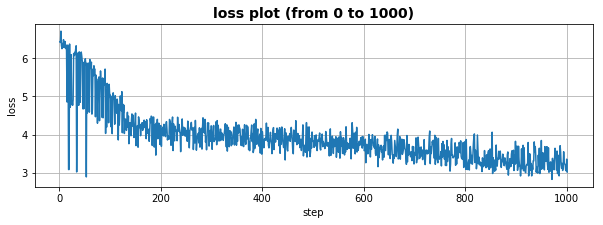

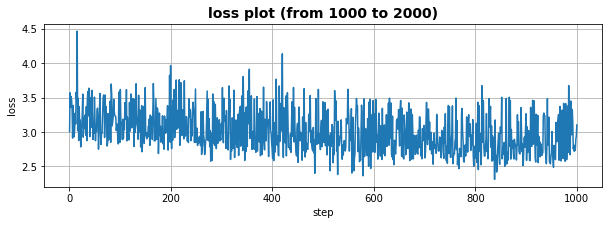

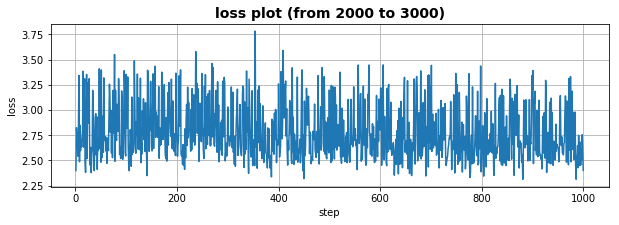

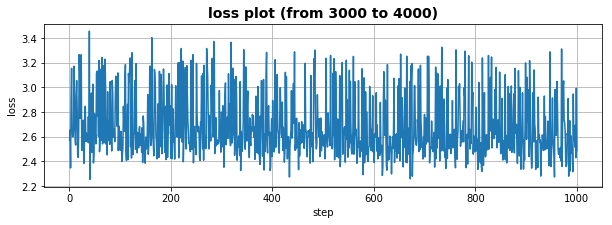

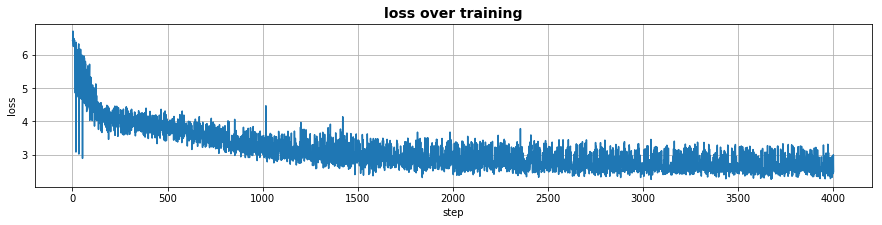

In [40]:
encoder = EncoderRNN(eng_enc_v_size, hidden_size)
decoder = DecoderRNN(hidden_size, eng_dec_v_size)

trainIters(encoder=encoder,
           decoder=decoder,
           n_iters=5000,
           pairs=training_pairs_A,
           valid_pairs=valid_pairs_A,
           encoder_path="encoder2.pkl",
           decoder_path="decoder2.pkl",
           status_every=1000,
           learning_rate=0.01,
           teacher_forcing_ratio=0.2)


save_translation(training_pairs_A,
                 encoder,
                 decoder,
                 MAX_LENGTH,
                 "training2.csv")

### Training 3

mean training loss = 2.81
mean valid loss = 2.58
time in 1000 steps: 0m 6s

mean training loss = 2.55
mean valid loss = 2.33
time in 1000 steps: 0m 6s

mean training loss = 2.44
mean valid loss = 2.49
time in 1000 steps: 0m 6s

mean training loss = 2.30
mean valid loss = 2.47
time in 1000 steps: 0m 5s



/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


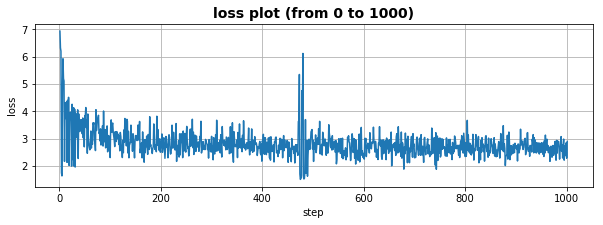

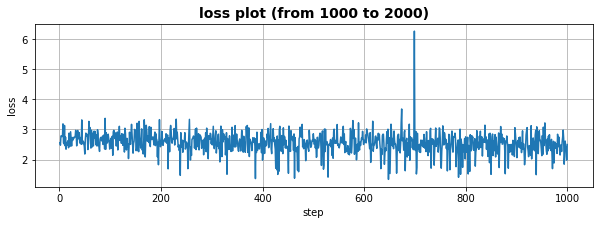

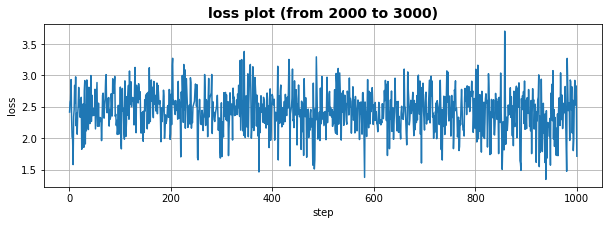

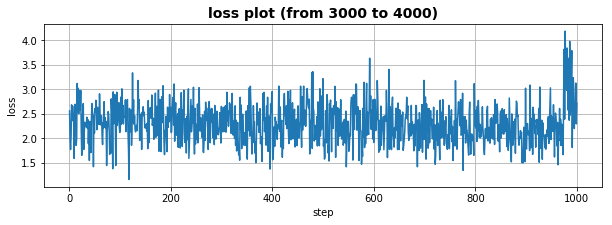

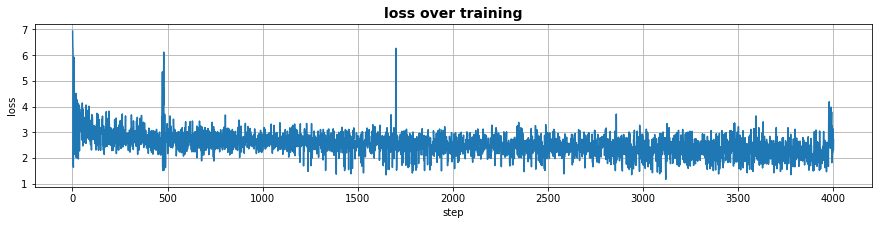

In [41]:
encoder = EncoderRNN(eng_enc_v_size, hidden_size)
decoder = DecoderRNN(hidden_size, eng_dec_v_size)

trainIters(encoder=encoder,
           decoder=decoder,
           n_iters=5000,
           pairs=training_pairs_A,
           valid_pairs=valid_pairs_A,
           encoder_path="encoder3.pkl",
           decoder_path="decoder3.pkl",
           status_every=1000,
           learning_rate=0.2,
           teacher_forcing_ratio=0.2)


save_translation(training_pairs_A,
                 encoder,
                 decoder,
                 MAX_LENGTH,
                 "training3.csv")

### Training 4

mean training loss = 3.40
mean valid loss = 2.95
time in 200 steps: 0m 1s

mean training loss = 2.63
mean valid loss = 2.09
time in 200 steps: 0m 1s

mean training loss = 1.96
mean valid loss = 1.85
time in 200 steps: 0m 1s

mean training loss = 1.80
mean valid loss = 1.86
time in 200 steps: 0m 1s

mean training loss = 1.70
mean valid loss = 1.92
time in 200 steps: 0m 1s

mean training loss = 1.69
mean valid loss = 1.65
time in 200 steps: 0m 2s

mean training loss = 1.56
mean valid loss = 1.47
time in 200 steps: 0m 1s

mean training loss = 1.42
mean valid loss = 1.52
time in 200 steps: 0m 1s

mean training loss = 1.32
mean valid loss = 1.22
time in 200 steps: 0m 1s

mean training loss = 1.23
mean valid loss = 1.25
time in 200 steps: 0m 1s

mean training loss = 1.07
mean valid loss = 1.16
time in 200 steps: 0m 1s

mean training loss = 1.05
mean valid loss = 1.03
time in 200 steps: 0m 1s

mean training loss = 0.89
mean valid loss = 0.99
time in 200 steps: 0m 2s

mean training loss = 0.80

/home/felsal/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


mean training loss = 0.23
mean valid loss = 0.31
time in 200 steps: 0m 2s

mean training loss = 0.17
mean valid loss = 0.24
time in 200 steps: 0m 1s

mean training loss = 0.15
mean valid loss = 0.16
time in 200 steps: 0m 2s



/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


mean blue score over training data = 0.974
mean acc over training data = 0.910


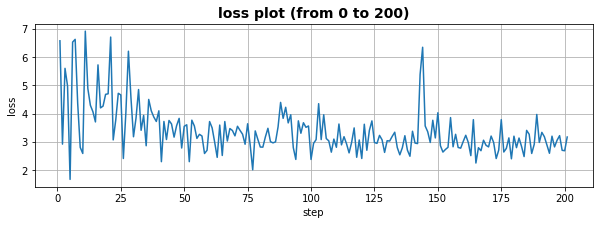

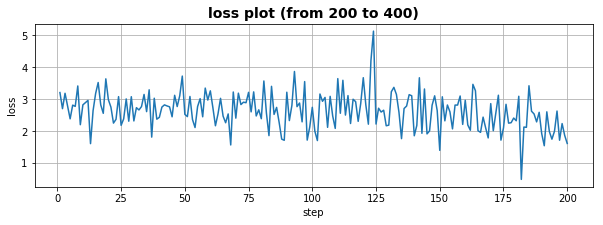

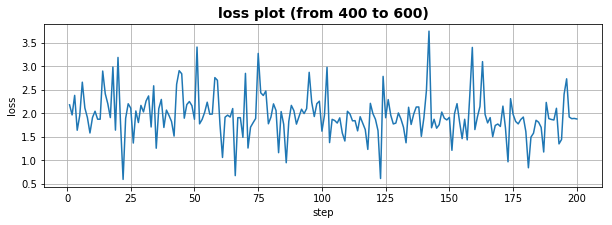

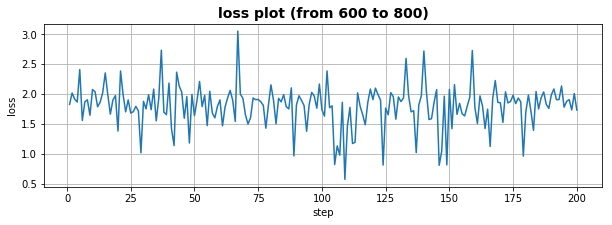

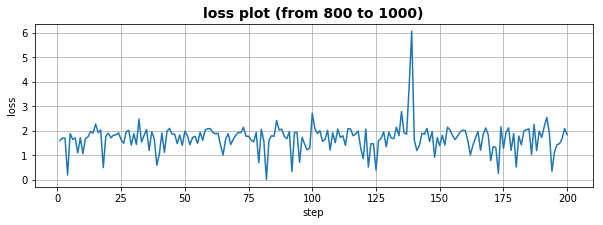

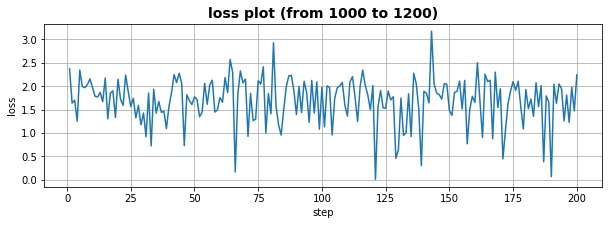

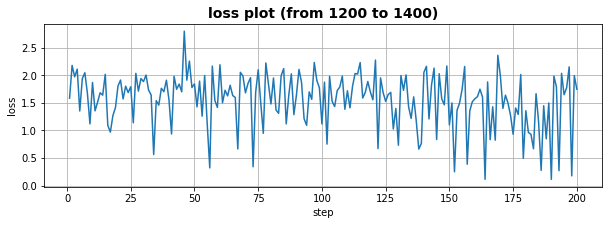

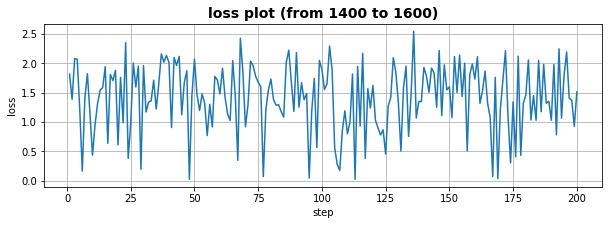

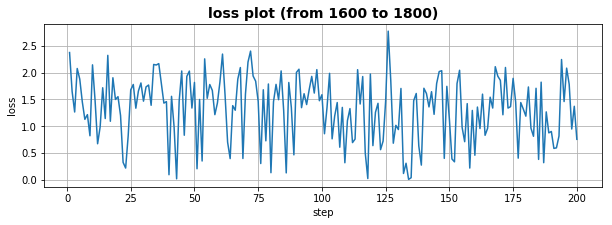

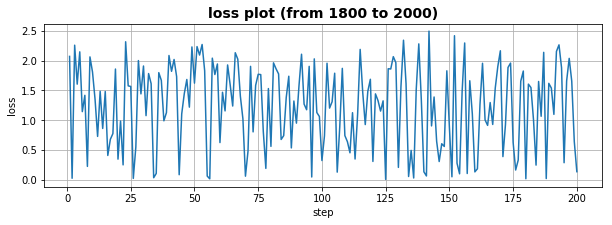

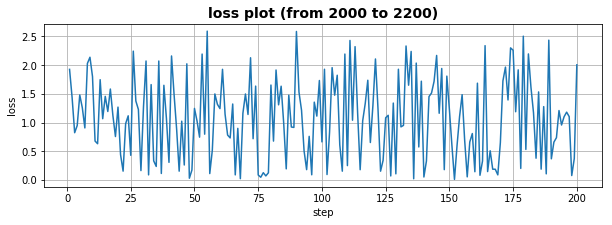

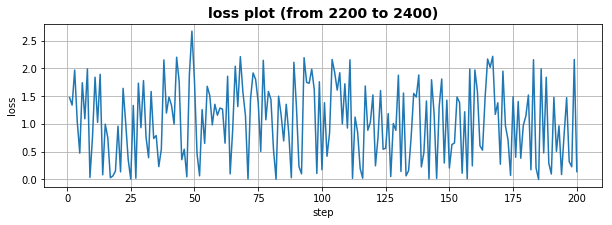

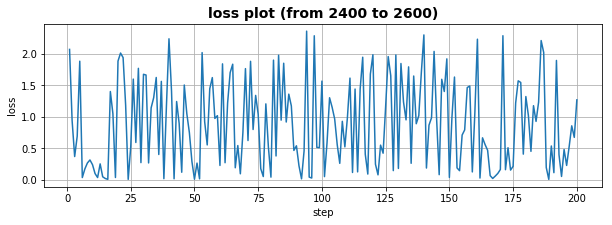

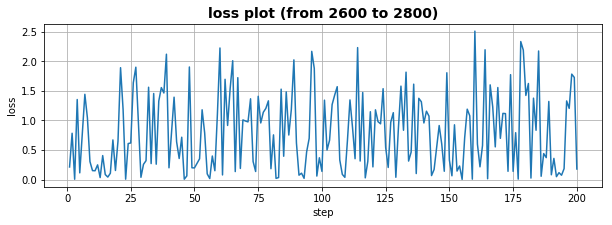

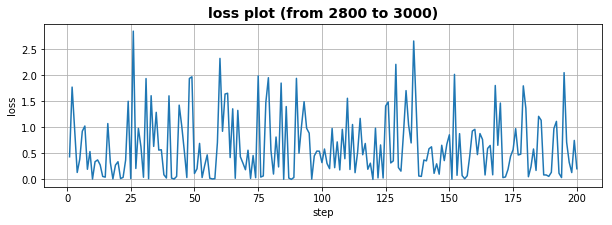

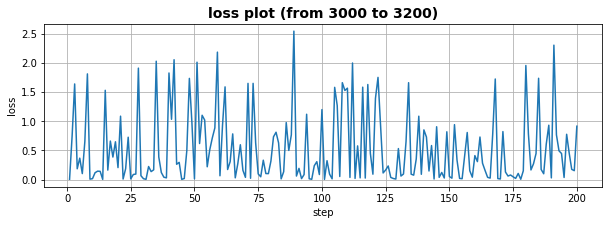

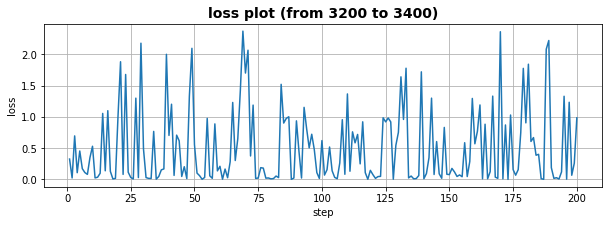

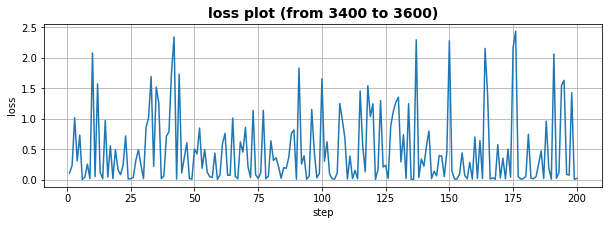

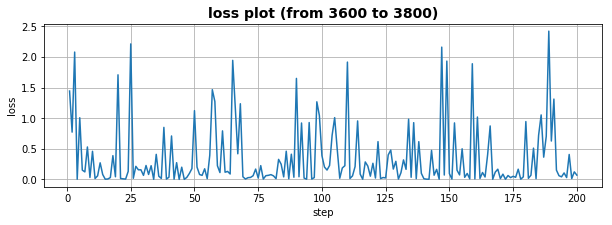

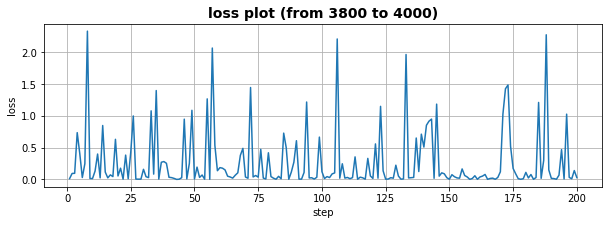

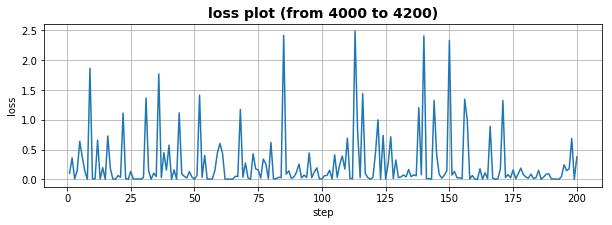

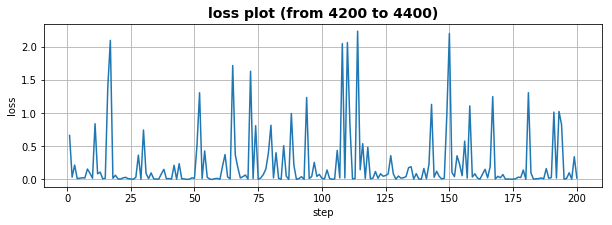

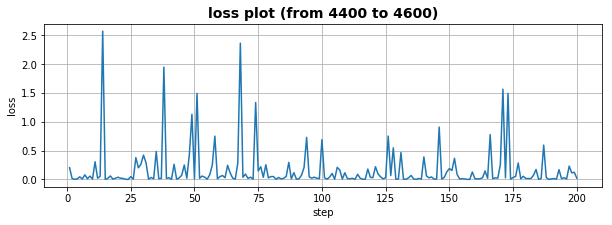

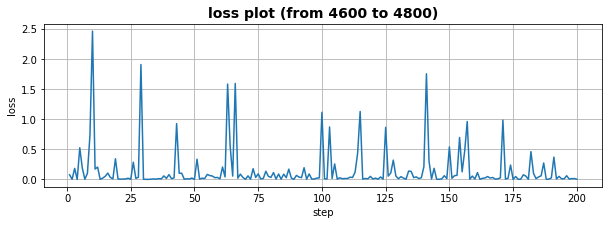

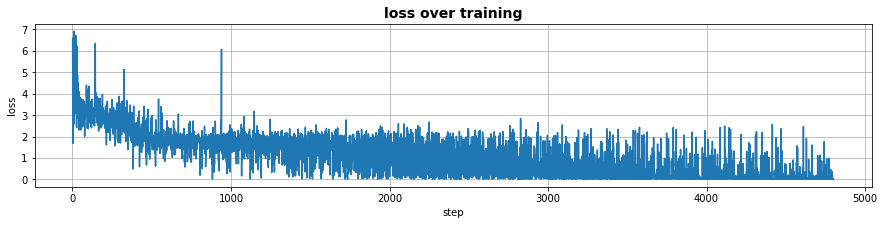

In [42]:
hidden_size = 100

encoder = EncoderRNN(eng_enc_v_size, hidden_size)
decoder = DecoderRNN(hidden_size, eng_dec_v_size)

trainIters(encoder=encoder,
           decoder=decoder,
           n_iters=5000,
           pairs=training_pairs_A,
           valid_pairs=valid_pairs_A,
           encoder_path="encoder4.pkl",
           decoder_path="decoder4.pkl",
           status_every=200,
           learning_rate=0.2,
           teacher_forcing_ratio=0.2)


save_translation(training_pairs_A,
                 encoder,
                 decoder,
                 MAX_LENGTH,
                 "training4.csv")

df_results = pd.read_csv("training4.csv")
acc = np.mean(df_results.accuracy.values)
blue = np.mean(df_results.blue.values)
print("mean blue score over training data = {:.3f}".format(blue))
print("mean acc over training data = {:.3f}".format(acc))

mean training loss = 3.07
mean valid loss = 2.25
time in 200 steps: 0m 1s

mean training loss = 1.95
mean valid loss = 1.80
time in 200 steps: 0m 1s

mean training loss = 1.83
mean valid loss = 1.85
time in 200 steps: 0m 1s

mean training loss = 1.64
mean valid loss = 1.56
time in 200 steps: 0m 2s

mean training loss = 1.49
mean valid loss = 1.45
time in 200 steps: 0m 1s

mean training loss = 1.25
mean valid loss = 1.21
time in 200 steps: 0m 1s

mean training loss = 1.21
mean valid loss = 1.15
time in 200 steps: 0m 1s

mean training loss = 0.94
mean valid loss = 1.01
time in 200 steps: 0m 1s

mean training loss = 0.89
mean valid loss = 0.88
time in 200 steps: 0m 2s

mean training loss = 0.78
mean valid loss = 0.73
time in 200 steps: 0m 1s

mean training loss = 0.51
mean valid loss = 0.28
time in 200 steps: 0m 2s

mean training loss = 0.48
mean valid loss = 0.41
time in 200 steps: 0m 1s

mean training loss = 0.44
mean valid loss = 0.44
time in 200 steps: 0m 1s

mean training loss = 0.25

/home/felsal/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


mean training loss = 0.04
mean valid loss = 0.06
time in 200 steps: 0m 2s

mean training loss = 0.03
mean valid loss = 0.01
time in 200 steps: 0m 1s

mean training loss = 0.05
mean valid loss = 0.02
time in 200 steps: 0m 2s



/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


mean blue score over training data = 0.997
mean acc over training data = 0.989


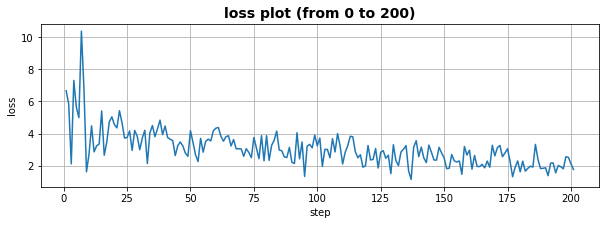

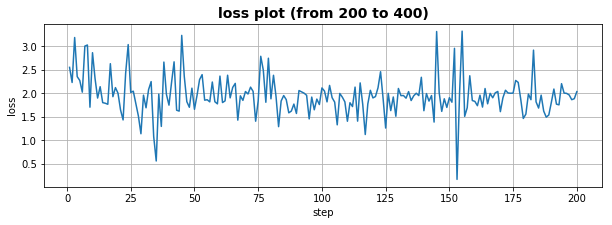

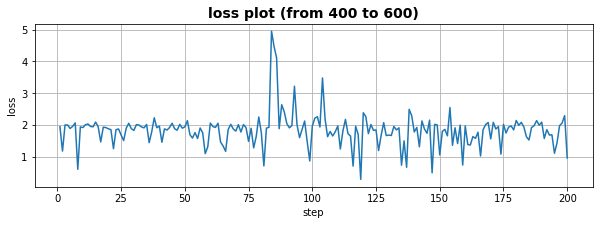

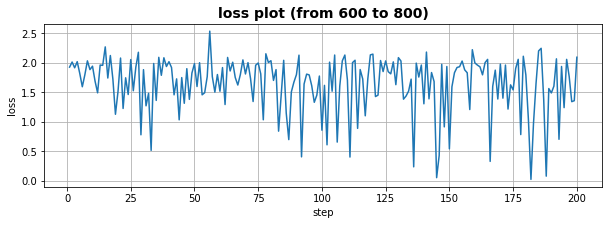

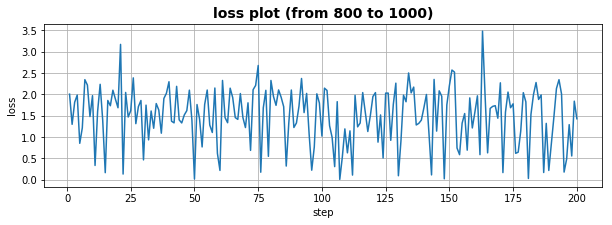

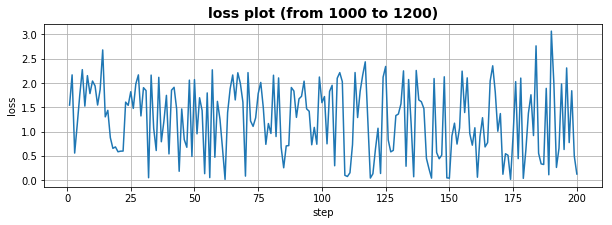

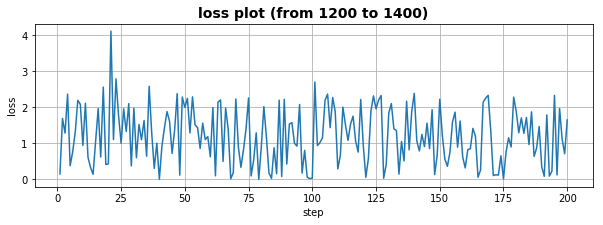

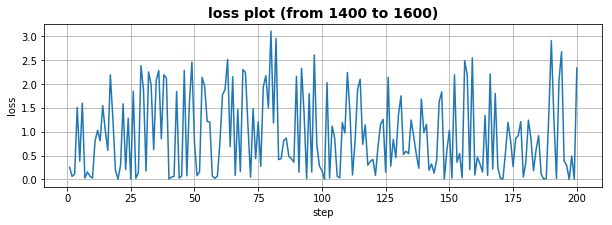

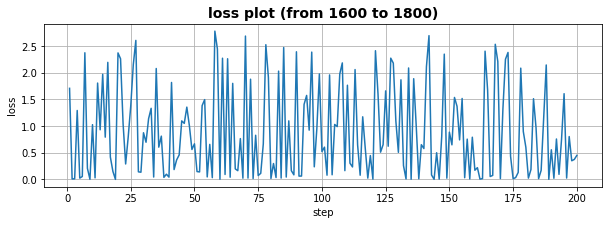

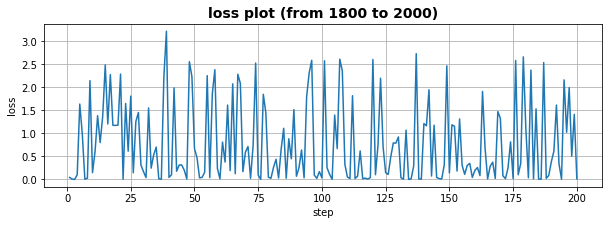

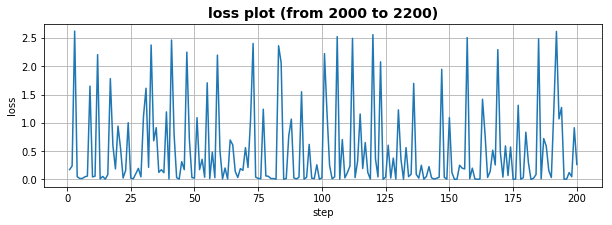

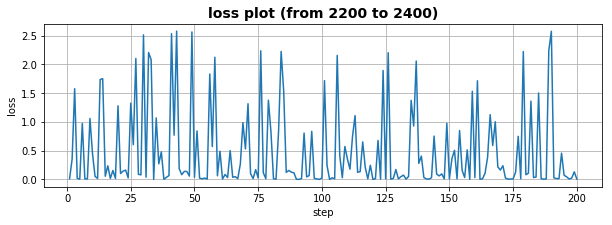

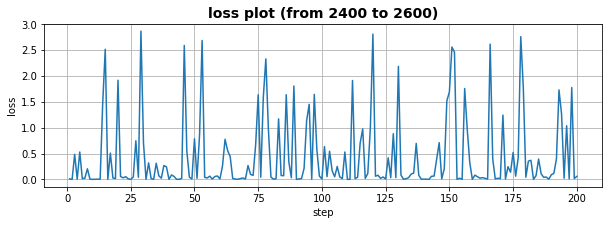

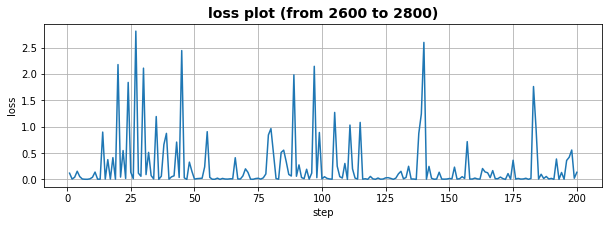

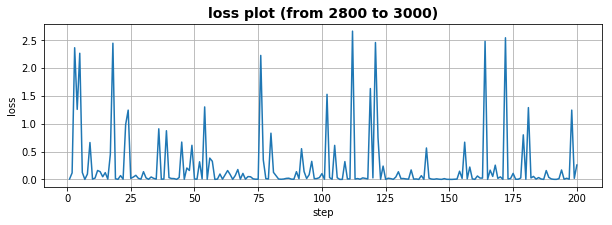

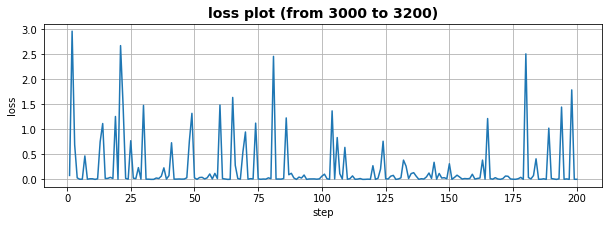

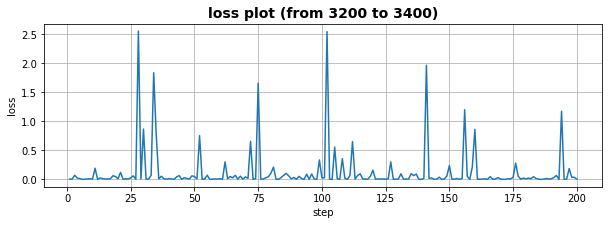

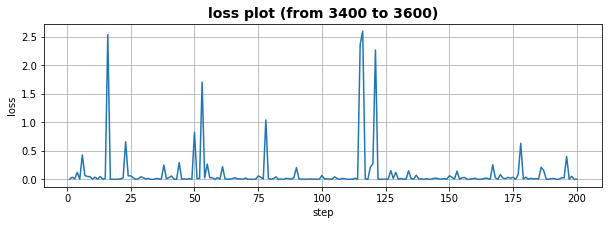

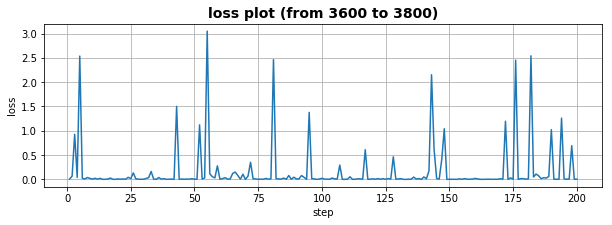

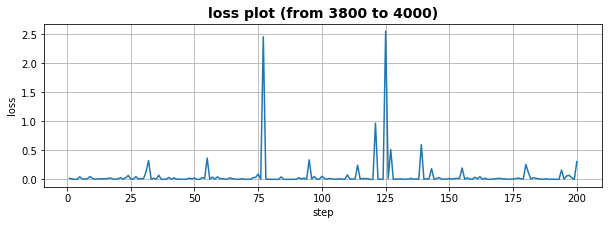

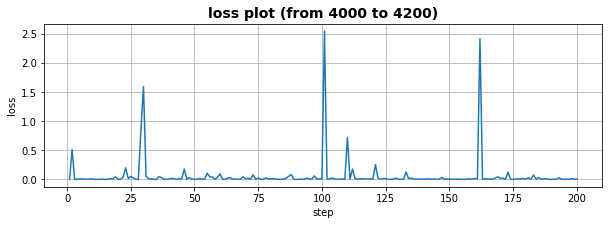

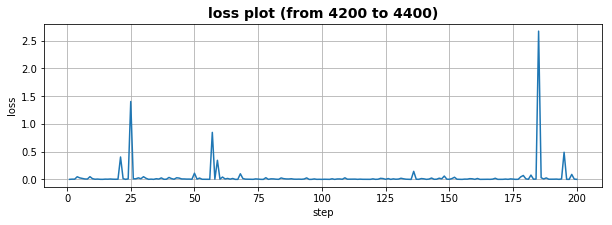

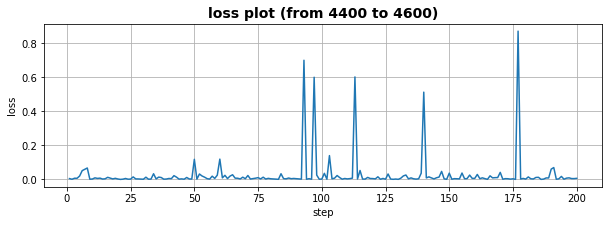

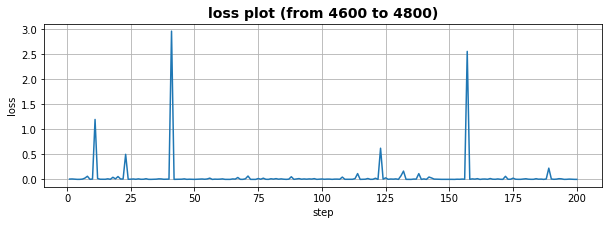

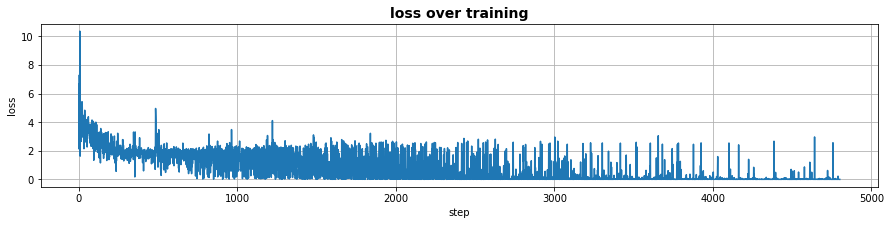

In [43]:
hidden_size = 100

encoder = EncoderRNN(eng_enc_v_size, hidden_size)
decoder = DecoderRNN(hidden_size, eng_dec_v_size)

trainIters(encoder=encoder,
           decoder=decoder,
           n_iters=5000,
           pairs=training_pairs_B,
           valid_pairs=valid_pairs_B,
           encoder_path="encoder5.pkl",
           decoder_path="decoder5.pkl",
           status_every=200,
           learning_rate=0.2,
           teacher_forcing_ratio=0.2)


save_translation(training_pairs_B,
                 encoder,
                 decoder,
                 MAX_LENGTH,
                 "training5.csv")

df_results = pd.read_csv("training5.csv")
acc = np.mean(df_results.accuracy.values)
blue = np.mean(df_results.blue.values)
print("mean blue score over training data = {:.3f}".format(blue))
print("mean acc over training data = {:.3f}".format(acc))

### Evaluating the trained models

### and A

In [44]:
hidden_size = 100

encoder = EncoderRNN(eng_enc_v_size, hidden_size)
decoder = DecoderRNN(hidden_size, eng_dec_v_size)

encoder.load_state_dict(torch.load("encoder4.pkl"))
decoder.load_state_dict(torch.load("decoder4.pkl"))

In [45]:
save_translation(training_pairs_A,
                 encoder,
                 decoder,
                 MAX_LENGTH,
                 "training4.csv")

df_results = pd.read_csv("training4.csv")
acc = np.mean(df_results.accuracy.values)
blue = np.mean(df_results.blue.values)
print("mean blue score over training data = {:.3f}".format(blue))
print("mean acc over training data = {:.3f}".format(acc))

/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


mean blue score over training data = 0.966
mean acc over training data = 0.885


In [46]:
save_translation(valid_pairs_A,
                 encoder,
                 decoder,
                 MAX_LENGTH,
                 "valid4.csv")

df_results = pd.read_csv("valid4.csv")
acc = np.mean(df_results.accuracy.values)
blue = np.mean(df_results.blue.values)
print("mean blue score over valid data = {:.3f}".format(blue))
print("mean acc over valid data = {:.3f}".format(acc))

/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


mean blue score over valid data = 0.954
mean acc over valid data = 0.843


### and B

In [47]:
hidden_size = 100

encoder = EncoderRNN(eng_enc_v_size, hidden_size)
decoder = DecoderRNN(hidden_size, eng_dec_v_size)

encoder.load_state_dict(torch.load("encoder5.pkl"))
decoder.load_state_dict(torch.load("decoder5.pkl"))

In [48]:
save_translation(training_pairs_B,
                 encoder,
                 decoder,
                 MAX_LENGTH,
                 "training5.csv")

df_results = pd.read_csv("training5.csv")
acc = np.mean(df_results.accuracy.values)
blue = np.mean(df_results.blue.values)
print("mean blue score over training data = {:.3f}".format(blue))
print("mean acc over training data = {:.3f}".format(acc))

/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


mean blue score over training data = 0.994
mean acc over training data = 0.979


In [49]:
save_translation(valid_pairs_B,
                 encoder,
                 decoder,
                 MAX_LENGTH,
                 "valid5.csv")

df_results = pd.read_csv("valid5.csv")
acc = np.mean(df_results.accuracy.values)
blue = np.mean(df_results.blue.values)
print("mean blue score over valid data = {:.3f}".format(blue))
print("mean acc over valid data = {:.3f}".format(acc))

/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


mean blue score over valid data = 0.991
mean acc over valid data = 0.971
